In [76]:
#---- to do list -----
# err_data_list 파일자동화
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

from tensorflow.python.keras.optimizer_v2.rmsprop import RMSProp
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv, DataFrame, concat
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, RepeatVector, LSTM, Input, TimeDistributed, Activation, Dropout
from keras.optimizers import SGD
np.set_printoptions(suppress=True)

#pow 낮값만 추출 test
#pow = 0인 구간 : 0~4, 21-23시
powhr_start = 5
powhr_end   = 20

shift_days  = 3
hoursteps   = powhr_end-powhr_start+1 #(16)
timesteps   = shift_days*hoursteps #hours step

data_dim    = 15
out_dim     = 1

n_model    = 10

season_mod = 'all_1030_5'
date_start = '10100901'
date_end   = '30191201'

err_date_list = ['20190912',
                    '20191122',
                    '20191130',
                    '20191217',
                    '20200501',
                    '20200502',
                    '20191028',
                    '20191107',
                    '20191108',
                    '20191109',
                    '20191110',
                    '20191111',
                    '20191112',
                    '20200214',
                    '20200307',
                    '20200308',
                    '20200309',
                    '20200310',
                    '20200328',
                    '20200329',
                    '20200625',
                    '20200809']

# Yeo-JohnsonTransformer

In [77]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer 

transf_type = 'yeo-johnson'
#transf_type = 'box-cox'

def yeo_johnson_transform(dataset):
    
    column_trans = ColumnTransformer(
                    [('sunshine', PowerTransformer(method=transf_type, standardize=True), ['sunshine']),
                     ('humdt', PowerTransformer(method=transf_type, standardize=True), ['humdt']),
                     ('wnd_spd', PowerTransformer(method=transf_type, standardize=True), ['wnd_spd']),
                     ('visiblt', PowerTransformer(method=transf_type, standardize=True), ['visiblt']),
                     ('cloud2', PowerTransformer(method=transf_type, standardize=True), ['cloud2']),
                     ('cloud', PowerTransformer(method=transf_type, standardize=True), ['cloud']),
                     ('grd_temprt', PowerTransformer(method=transf_type, standardize=True), ['grd_temprt']),
                     ('wnd_dir', PowerTransformer(method=transf_type, standardize=True), ['wnd_dir']),
                     ('dewpnt', PowerTransformer(method=transf_type, standardize=True), ['dewpnt']),
                     ('steampressr', PowerTransformer(method=transf_type, standardize=True), ['steampressr']),
                     ('temprt', PowerTransformer(method=transf_type, standardize=True), ['temprt']),
                     ('mincloud', PowerTransformer(method=transf_type, standardize=True), ['mincloud']),
                     ('rain', PowerTransformer(method=transf_type, standardize=True), ['rain']),
                     ('pressr', PowerTransformer(method=transf_type, standardize=True), ['pressr']),
                     ('seapressr', PowerTransformer(method=transf_type, standardize=True), ['seapressr']),
                     ('snow', PowerTransformer(method=transf_type, standardize=True), ['snow'])
                    ])
    
    transformed_data = column_trans.fit_transform(dataset)
    transformed_df = pd.DataFrame(transformed_data, columns=dataset.columns)
    pd.concat([transformed_df], axis = 1)
                    
    return transformed_df

# Get weather, pow data

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import fnmatch
from pandas import read_csv
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer 
#from feature_engine import variable_transformers as vt
from scipy.stats import yeojohnson

dir_path = 'C:/Users/VISLAB_PHY/Desktop/D_WORKSPACE/Data/'

#############################################
# 태양광 전력
#############################################
def get_pow():

    # pow 파일 load
    dir_path = 'C:/Users/VISLAB_PHY/Desktop/D_WORKSPACE/Data/'
    dir_path    = dir_path+"/pow_24/UR00000126_csv"
    file_list   = os.listdir(dir_path)
    print(len(file_list))
    hrPow  = []    

    # pow측정값 에러가 큰 일자 제거
    for filename in file_list:
        if (filename[:-4] not in err_date_list):
            if ((filename[:-4]>=date_start) & (filename<date_end)):
                filedata = pd.read_csv(dir_path+'/'+filename).values[:,0]
                hrPow.append(filedata)
                
    #낮시간 추출 (5~20시)
    pow_dataset = pd.DataFrame(hrPow)
    pow_dataset =pow_dataset.iloc[:,powhr_start:powhr_end+1]
    #pow_dataset.to_csv("C:/Users/VISLAB_PHY/Desktop/WORKSPACE/Origin/data/pow_hr.csv",mode='w',index=False)

    # 결측값 보간, reshape
    pow_dataset = pow_dataset.interpolate(method='linear')
    pow_dataset = pow_dataset.values.reshape(-1,1)
    pow_dataset = pd.DataFrame(pow_dataset)
    pow_dataset.columns = ['pow']
    pow_dataset.to_csv(dir_path+"/pow_210405.csv",mode='w',index=False)

    
    # scale
    sc_pow = MinMaxScaler(feature_range = (0, 1))
    scaled_pow = sc_pow.fit_transform(pow_dataset.values)
    df_pow = pd.DataFrame(scaled_pow, columns=pow_dataset.columns, index=list(pow_dataset.index.values))
    
    return df_pow, sc_pow

#############################################
# 종관기상관측
#############################################
def get_weather():
    # pow 파일 load
    file_list   = os.listdir(dir_path)
    print(len(file_list))
    for filename in os.listdir(dir_path):
        if fnmatch.fnmatch(filename, 'OBS_ASOS_TIM_*.csv'):
            print(filename)

            # load csv data
            dataset = read_csv(dir_path+'/'+filename, encoding='CP949')
            dataset.drop(['지점','지점명'], axis=1, inplace=True)
            dataset.drop(['기온 QC플래그','강수량 QC플래그','풍속 QC플래그','풍향 QC플래그','습도 QC플래그'], axis=1, inplace=True)
            dataset.drop(['현지기압 QC플래그','해면기압 QC플래그','일조 QC플래그','지면온도 QC플래그'], axis=1, inplace=True)
            dataset.drop(['5cm 지중온도(°C)','10cm 지중온도(°C)','20cm 지중온도(°C)','30cm 지중온도(°C)'], axis=1, inplace=True)
            dataset.drop(['3시간신적설(cm)','일사(MJ/m2)','운형(운형약어)','지면상태(지면상태코드)','현상번호(국내식)'], axis=1, inplace=True)

            # set column name
            dataset.columns = ['ymdhms', 'temprt', 'rain', 'wnd_spd', 'wnd_dir', 'humdt','steampressr',
                               'dewpnt', 'pressr','seapressr','sunshine','snow','cloud','cloud2','mincloud','visiblt','grd_temprt']

            # prioirty sort (피어슨상관계수)
            dataset = dataset[['ymdhms','sunshine','humdt','wnd_spd','visiblt','cloud2',
                               'cloud','grd_temprt','wnd_dir','dewpnt','steampressr','temprt',
                               'mincloud','rain','pressr','seapressr','snow']]


            # set NA data (관측값 0이 누적되어 결측된 경우. 0으로 세팅)
            dataset['rain'].fillna(0, inplace=True)     #강수량
            dataset['sunshine'].fillna(0, inplace=True) #일조
            dataset['snow'].fillna(0, inplace=True)     #적설량

            #일시 패턴 변환(2019-08-20 5:00 -> 2019082005)
            dataset['ymdhms'] = dataset['ymdhms'].str[0:4]+dataset['ymdhms'].str[5:7]+dataset['ymdhms'].str[8:10]+dataset['ymdhms'].str[11:13]
            # pow측정값 중 결측값 많은 일자 제거
            dataset = dataset[(dataset['ymdhms'].str[0:8]>=date_start) & (dataset['ymdhms'].str[0:8]<date_end)]
            for err_date in err_date_list:
                idx_err = dataset[dataset['ymdhms'].str.startswith(err_date)].index
                dataset = dataset.drop(idx_err)

            #낮시간 추출 (5~20시)
            dataset = dataset[(dataset['ymdhms'].str[-2:]>=str(powhr_start).rjust(2, '0')) &(dataset['ymdhms'].str[-2:]<=str(powhr_end))]
            dataset = dataset.interpolate(method='linear')# 결측값 보간
            
            # save file (test용)
            dataset.to_csv(dir_path+"/weather_210405.csv",mode='w',index=False)

            # normalization
            dataset.drop(['ymdhms'], axis=1, inplace=True)
            dataset = dataset.astype('float32')
            dataset = dataset.interpolate(method='linear')
            
            #YEO-JOHNSON transform
            #yeo_df = yeo_johnson_transform(dataset)
            yeo_df = dataset
            #insert feature (test)
            yeo_df.insert(2, 'temp_press', yeo_df['temprt']-yeo_df['steampressr'], True)
            yeo_df.insert(2, 'sunshine_humdt', abs(yeo_df['sunshine'])-(yeo_df['humdt']*(2.1)), True)#0.35
            
            sc = MinMaxScaler(feature_range = (0, 1))#scale
            scaled_weather = sc.fit_transform(yeo_df.values)
            weather = pd.DataFrame(scaled_weather, columns=yeo_df.columns, index=list(yeo_df.index.values))
            
            weather = weather.iloc[:, 0:data_dim] #feature size 조절
            
    return weather


# Numpy data
weather, pow

In [79]:
#############################################
# numpy data 만들기
#############################################

df_pow, sc_pow   = get_pow()
df               = get_weather()

# pow + weather + powY
df.insert(0, 'pow', df_pow.values, True)
df = df.iloc[0:-timesteps, :]
df.insert(df.shape[1], 'pow_Y', df_pow.iloc[timesteps:, :].values, True)

df.to_csv(dir_path+"/total_210405.csv",mode='w',index=False, encoding='CP949')


338
21
OBS_ASOS_TIM_20200929025447.csv


In [80]:
#dir_path = 'C:/Users/VISLAB_PHY/Desktop/D_WORKSPACE/Data/'
#df = read_csv(dir_path+'total.csv', encoding='CP949')
#----------------------------------------------
# time step만큼 window 움직여 dataset 생성
#----------------------------------------------
totalsize = df.shape[0]
dataX, dataY = [], []

for i in range(0, totalsize-timesteps-24+1, hoursteps):
    dataX.append(df.iloc[i:(i + timesteps),0:-1])
    dataY.append(df.iloc[i:(i + hoursteps),[0]])

print("len(dataX) : ", len(dataX), dataX[0].shape)
print("len(dataY) : ", len(dataY), dataY[0].shape)

#----------------------------------------------
#  Split train/test 
#----------------------------------------------

train_size = int(len(dataX) * 0.7)
val_size   = int(len(dataX) * 0.2)
test_size  = len(dataX) - train_size - val_size
val_idx = train_size+val_size

trainX, valX, testX = np.array(dataX[0:train_size]), np.array(dataX[train_size:val_idx]), np.array(dataX[val_idx:val_idx+test_size])
trainY, valY, testY = np.array(dataY[0:train_size]), np.array(dataY[train_size:val_idx]), np.array(dataY[val_idx:val_idx+test_size])

print('train X : ', trainX.shape, '\tY : ', trainY.shape)
print('val   X : ', valX.shape,   '\tY : ', valY.shape)
print('test  X : ', testX.shape,  '\tY : ', testY.shape)

np.save("npset/"+season_mod+"_trainX",trainX)
np.save("npset/"+season_mod+"_trainY",trainY)
np.save("npset/"+season_mod+"_valX",valX)
np.save("npset/"+season_mod+"_valY",valY)
np.save("npset/"+season_mod+"_testX",testX)
np.save("npset/"+season_mod+"_testY",testY)


# 모델 1

len(dataX) :  327 (48, 16)
len(dataY) :  327 (16, 1)
train X :  (228, 48, 16) 	Y :  (228, 16, 1)
val   X :  (65, 48, 16) 	Y :  (65, 16, 1)
test  X :  (34, 48, 16) 	Y :  (34, 16, 1)


In [81]:
import tensorflow as tf

model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(256, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(tf.keras.layers.RepeatVector(data_dim+1))
model.add(tf.keras.layers.LSTM(256, return_sequences=True))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(256, activation='relu')))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1)))
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 256)               279552    
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 16, 256)           0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 16, 256)           525312    
_________________________________________________________________
time_distributed_6 (TimeDist (None, 16, 256)           65792     
_________________________________________________________________
time_distributed_7 (TimeDist (None, 16, 1)             257       
Total params: 870,913
Trainable params: 870,913
Non-trainable params: 0
_________________________________________________________________


# 모델 fit 반복돌리기
range 바꾸기

In [82]:
for i in range(n_model):#0,5):#

    #keras.optimizers.RMSprop(lr=0.005, rho=0.9, epsilon=None, decay=0.0)
    model.compile(loss='mean_squared_error', 
                  optimizer=RMSProp()
                  #optimizer=RMSProp(learning_rate=0.001)
                  #optimizer=SGD(lr=0.01, momentum=0.9, nesterov=True), 
                  #metrics=['acc'])
                 )

    hist = model.fit(trainX, 
                     trainY, 
                     epochs=200, 
                     batch_size=64,
                     validation_data=(valX, valY))


    results = model.evaluate(testX, testY)
    #model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

    model.save('model/model_'+season_mod+'_'+str(i)+'.h5')# # of feature=3,5,7,9,?,12,14,16,18

Train on 228 samples, validate on 65 samples
Epoch 1/200
228/228 [==============================] - 3s 14ms/sample - loss: 0.2851 - val_loss: 0.0396
Epoch 2/200
228/228 [==============================] - 0s 215us/sample - loss: 0.0379 - val_loss: 0.0379
Epoch 3/200
228/228 [==============================] - 0s 205us/sample - loss: 0.0354 - val_loss: 0.0375
Epoch 4/200
228/228 [==============================] - 0s 206us/sample - loss: 0.0370 - val_loss: 0.0343
Epoch 5/200
228/228 [==============================] - 0s 206us/sample - loss: 0.0328 - val_loss: 0.0337
Epoch 6/200
228/228 [==============================] - 0s 197us/sample - loss: 0.0394 - val_loss: 0.0709
Epoch 7/200
228/228 [==============================] - 0s 188us/sample - loss: 0.0465 - val_loss: 0.0358
Epoch 8/200
228/228 [==============================] - 0s 184us/sample - loss: 0.0335 - val_loss: 0.0322
Epoch 9/200
228/228 [==============================] - 0s 179us/sample - loss: 0.0356 - val_loss: 0.0342
Epoch 10/20

Epoch 78/200
228/228 [==============================] - 0s 184us/sample - loss: 0.0284 - val_loss: 0.0091
Epoch 79/200
228/228 [==============================] - 0s 188us/sample - loss: 0.0069 - val_loss: 0.0056
Epoch 80/200
228/228 [==============================] - 0s 179us/sample - loss: 0.0045 - val_loss: 0.0048
Epoch 81/200
228/228 [==============================] - 0s 179us/sample - loss: 0.0037 - val_loss: 0.0090
Epoch 82/200
228/228 [==============================] - 0s 184us/sample - loss: 0.0064 - val_loss: 0.0065
Epoch 83/200
228/228 [==============================] - 0s 192us/sample - loss: 0.0046 - val_loss: 0.0074
Epoch 84/200
228/228 [==============================] - 0s 197us/sample - loss: 0.0056 - val_loss: 0.0068
Epoch 85/200
228/228 [==============================] - 0s 201us/sample - loss: 0.0084 - val_loss: 0.0050
Epoch 86/200
228/228 [==============================] - 0s 188us/sample - loss: 0.0053 - val_loss: 0.0050
Epoch 87/200
228/228 [========================

Epoch 155/200
228/228 [==============================] - 0s 179us/sample - loss: 0.0024 - val_loss: 0.0065
Epoch 156/200
228/228 [==============================] - 0s 179us/sample - loss: 0.0035 - val_loss: 0.0069
Epoch 157/200
228/228 [==============================] - 0s 179us/sample - loss: 0.0037 - val_loss: 0.0059
Epoch 158/200
228/228 [==============================] - 0s 184us/sample - loss: 0.0026 - val_loss: 0.0073
Epoch 159/200
228/228 [==============================] - 0s 184us/sample - loss: 0.0032 - val_loss: 0.0044
Epoch 160/200
228/228 [==============================] - 0s 188us/sample - loss: 0.0027 - val_loss: 0.0058
Epoch 161/200
228/228 [==============================] - 0s 184us/sample - loss: 0.0041 - val_loss: 0.0231
Epoch 162/200
228/228 [==============================] - 0s 188us/sample - loss: 0.0089 - val_loss: 0.0048
Epoch 163/200
228/228 [==============================] - 0s 197us/sample - loss: 0.0037 - val_loss: 0.0035
Epoch 164/200
228/228 [==============

228/228 [==============================] - 0s 179us/sample - loss: 0.0025 - val_loss: 0.0048
Epoch 22/200
228/228 [==============================] - 0s 184us/sample - loss: 0.0030 - val_loss: 0.0031
Epoch 23/200
228/228 [==============================] - 0s 184us/sample - loss: 0.0023 - val_loss: 0.0108
Epoch 24/200
228/228 [==============================] - 0s 188us/sample - loss: 0.0034 - val_loss: 0.0032
Epoch 25/200
228/228 [==============================] - 0s 184us/sample - loss: 0.0030 - val_loss: 0.0051
Epoch 26/200
228/228 [==============================] - 0s 188us/sample - loss: 0.0028 - val_loss: 0.0033
Epoch 27/200
228/228 [==============================] - 0s 188us/sample - loss: 0.0020 - val_loss: 0.0031
Epoch 28/200
228/228 [==============================] - 0s 184us/sample - loss: 0.0016 - val_loss: 0.0032
Epoch 29/200
228/228 [==============================] - 0s 197us/sample - loss: 0.0014 - val_loss: 0.0070
Epoch 30/200
228/228 [==============================] - 0s 

228/228 [==============================] - 0s 184us/sample - loss: 0.0020 - val_loss: 0.0042
Epoch 99/200
228/228 [==============================] - 0s 184us/sample - loss: 0.0024 - val_loss: 0.0051
Epoch 100/200
228/228 [==============================] - 0s 179us/sample - loss: 0.0032 - val_loss: 0.0057
Epoch 101/200
228/228 [==============================] - 0s 192us/sample - loss: 0.0016 - val_loss: 0.0033
Epoch 102/200
228/228 [==============================] - 0s 179us/sample - loss: 0.0014 - val_loss: 0.0027
Epoch 103/200
228/228 [==============================] - 0s 184us/sample - loss: 0.0012 - val_loss: 0.0038
Epoch 104/200
228/228 [==============================] - 0s 184us/sample - loss: 0.0015 - val_loss: 0.0150
Epoch 105/200
228/228 [==============================] - 0s 192us/sample - loss: 0.0064 - val_loss: 0.0041
Epoch 106/200
228/228 [==============================] - 0s 179us/sample - loss: 0.0013 - val_loss: 0.0034
Epoch 107/200
228/228 [=============================

228/228 [==============================] - 0s 192us/sample - loss: 0.0027 - val_loss: 0.0044
Epoch 175/200
228/228 [==============================] - 0s 184us/sample - loss: 9.1190e-04 - val_loss: 0.0047
Epoch 176/200
228/228 [==============================] - 0s 192us/sample - loss: 0.0014 - val_loss: 0.0067
Epoch 177/200
228/228 [==============================] - 0s 184us/sample - loss: 0.0015 - val_loss: 0.0044
Epoch 178/200
228/228 [==============================] - 0s 188us/sample - loss: 9.3376e-04 - val_loss: 0.0036
Epoch 179/200
228/228 [==============================] - 0s 192us/sample - loss: 0.0014 - val_loss: 0.0042
Epoch 180/200
228/228 [==============================] - 0s 188us/sample - loss: 0.0027 - val_loss: 0.0033
Epoch 181/200
228/228 [==============================] - 0s 192us/sample - loss: 8.9613e-04 - val_loss: 0.0035
Epoch 182/200
228/228 [==============================] - 0s 192us/sample - loss: 8.3233e-04 - val_loss: 0.0053
Epoch 183/200
228/228 [============

228/228 [==============================] - 0s 179us/sample - loss: 9.8825e-04 - val_loss: 0.0039
Epoch 41/200
228/228 [==============================] - 0s 188us/sample - loss: 0.0011 - val_loss: 0.0055
Epoch 42/200
228/228 [==============================] - 0s 179us/sample - loss: 0.0016 - val_loss: 0.0052
Epoch 43/200
228/228 [==============================] - 0s 188us/sample - loss: 0.0011 - val_loss: 0.0061
Epoch 44/200
228/228 [==============================] - 0s 179us/sample - loss: 0.0011 - val_loss: 0.0051
Epoch 45/200
228/228 [==============================] - 0s 188us/sample - loss: 9.5377e-04 - val_loss: 0.0055
Epoch 46/200
228/228 [==============================] - 0s 214us/sample - loss: 0.0011 - val_loss: 0.0061
Epoch 47/200
228/228 [==============================] - 0s 188us/sample - loss: 0.0012 - val_loss: 0.0049
Epoch 48/200
228/228 [==============================] - 0s 184us/sample - loss: 0.0011 - val_loss: 0.0055
Epoch 49/200
228/228 [=============================

Epoch 116/200
228/228 [==============================] - 0s 201us/sample - loss: 6.5458e-04 - val_loss: 0.0049
Epoch 117/200
228/228 [==============================] - 0s 197us/sample - loss: 0.0013 - val_loss: 0.0057
Epoch 118/200
228/228 [==============================] - 0s 188us/sample - loss: 7.3655e-04 - val_loss: 0.0047
Epoch 119/200
228/228 [==============================] - 0s 188us/sample - loss: 7.6155e-04 - val_loss: 0.0057
Epoch 120/200
228/228 [==============================] - 0s 184us/sample - loss: 9.6187e-04 - val_loss: 0.0045
Epoch 121/200
228/228 [==============================] - 0s 184us/sample - loss: 9.5267e-04 - val_loss: 0.0036
Epoch 122/200
228/228 [==============================] - 0s 197us/sample - loss: 0.0011 - val_loss: 0.0041
Epoch 123/200
228/228 [==============================] - 0s 184us/sample - loss: 9.2440e-04 - val_loss: 0.0039
Epoch 124/200
228/228 [==============================] - 0s 184us/sample - loss: 8.0600e-04 - val_loss: 0.0041
Epoch 125

228/228 [==============================] - 0s 179us/sample - loss: 7.3889e-04 - val_loss: 0.0046
Epoch 191/200
228/228 [==============================] - 0s 188us/sample - loss: 0.0010 - val_loss: 0.0043
Epoch 192/200
228/228 [==============================] - 0s 188us/sample - loss: 0.0010 - val_loss: 0.0044
Epoch 193/200
228/228 [==============================] - 0s 188us/sample - loss: 4.2701e-04 - val_loss: 0.0047
Epoch 194/200
228/228 [==============================] - 0s 179us/sample - loss: 4.4865e-04 - val_loss: 0.0052
Epoch 195/200
228/228 [==============================] - 0s 184us/sample - loss: 6.8916e-04 - val_loss: 0.0075
Epoch 196/200
228/228 [==============================] - 0s 184us/sample - loss: 0.0012 - val_loss: 0.0058
Epoch 197/200
228/228 [==============================] - 0s 188us/sample - loss: 0.0015 - val_loss: 0.0044
Epoch 198/200
228/228 [==============================] - 0s 201us/sample - loss: 6.1394e-04 - val_loss: 0.0048
Epoch 199/200
228/228 [========

228/228 [==============================] - 0s 179us/sample - loss: 5.2198e-04 - val_loss: 0.0052
Epoch 56/200
228/228 [==============================] - 0s 184us/sample - loss: 5.6001e-04 - val_loss: 0.0059
Epoch 57/200
228/228 [==============================] - 0s 188us/sample - loss: 7.3980e-04 - val_loss: 0.0070
Epoch 58/200
228/228 [==============================] - 0s 184us/sample - loss: 9.2589e-04 - val_loss: 0.0080
Epoch 59/200
228/228 [==============================] - 0s 188us/sample - loss: 8.6540e-04 - val_loss: 0.0049
Epoch 60/200
228/228 [==============================] - 0s 188us/sample - loss: 4.9584e-04 - val_loss: 0.0050
Epoch 61/200
228/228 [==============================] - 0s 184us/sample - loss: 3.9967e-04 - val_loss: 0.0049
Epoch 62/200
228/228 [==============================] - 0s 188us/sample - loss: 5.0708e-04 - val_loss: 0.0052
Epoch 63/200
228/228 [==============================] - 0s 188us/sample - loss: 8.0800e-04 - val_loss: 0.0054
Epoch 64/200
228/228 [=

228/228 [==============================] - 0s 192us/sample - loss: 3.5190e-04 - val_loss: 0.0054
Epoch 130/200
228/228 [==============================] - 0s 188us/sample - loss: 6.3075e-04 - val_loss: 0.0055
Epoch 131/200
228/228 [==============================] - 0s 188us/sample - loss: 6.9557e-04 - val_loss: 0.0069
Epoch 132/200
228/228 [==============================] - 0s 192us/sample - loss: 6.3785e-04 - val_loss: 0.0056
Epoch 133/200
228/228 [==============================] - 0s 188us/sample - loss: 3.4378e-04 - val_loss: 0.0057
Epoch 134/200
228/228 [==============================] - 0s 192us/sample - loss: 4.5119e-04 - val_loss: 0.0051
Epoch 135/200
228/228 [==============================] - 0s 201us/sample - loss: 3.7018e-04 - val_loss: 0.0044
Epoch 136/200
228/228 [==============================] - 0s 184us/sample - loss: 0.0011 - val_loss: 0.0049
Epoch 137/200
228/228 [==============================] - 0s 188us/sample - loss: 4.3984e-04 - val_loss: 0.0050
Epoch 138/200
228/2

Train on 228 samples, validate on 65 samples
Epoch 1/200
228/228 [==============================] - 6s 26ms/sample - loss: 0.0025 - val_loss: 0.0053
Epoch 2/200
228/228 [==============================] - 0s 219us/sample - loss: 9.5879e-04 - val_loss: 0.0057
Epoch 3/200
228/228 [==============================] - 0s 219us/sample - loss: 3.5564e-04 - val_loss: 0.0051
Epoch 4/200
228/228 [==============================] - 0s 210us/sample - loss: 2.1925e-04 - val_loss: 0.0055
Epoch 5/200
228/228 [==============================] - 0s 214us/sample - loss: 1.7836e-04 - val_loss: 0.0062
Epoch 6/200
228/228 [==============================] - 0s 201us/sample - loss: 5.2684e-04 - val_loss: 0.0064
Epoch 7/200
228/228 [==============================] - 0s 192us/sample - loss: 4.6662e-04 - val_loss: 0.0061
Epoch 8/200
228/228 [==============================] - 0s 197us/sample - loss: 5.7187e-04 - val_loss: 0.0052
Epoch 9/200
228/228 [==============================] - 0s 192us/sample - loss: 4.1854e-0

228/228 [==============================] - 0s 201us/sample - loss: 2.8303e-04 - val_loss: 0.0039
Epoch 76/200
228/228 [==============================] - 0s 197us/sample - loss: 4.4745e-04 - val_loss: 0.0045
Epoch 77/200
228/228 [==============================] - 0s 219us/sample - loss: 5.5499e-04 - val_loss: 0.0052
Epoch 78/200
228/228 [==============================] - 0s 210us/sample - loss: 5.6247e-04 - val_loss: 0.0049
Epoch 79/200
228/228 [==============================] - 0s 210us/sample - loss: 2.3898e-04 - val_loss: 0.0054
Epoch 80/200
228/228 [==============================] - 0s 201us/sample - loss: 3.6935e-04 - val_loss: 0.0063
Epoch 81/200
228/228 [==============================] - 0s 214us/sample - loss: 6.9561e-04 - val_loss: 0.0056
Epoch 82/200
228/228 [==============================] - 0s 232us/sample - loss: 3.7794e-04 - val_loss: 0.0057
Epoch 83/200
228/228 [==============================] - 0s 206us/sample - loss: 2.0419e-04 - val_loss: 0.0053
Epoch 84/200
228/228 [=

228/228 [==============================] - 0s 192us/sample - loss: 5.1557e-04 - val_loss: 0.0048
Epoch 150/200
228/228 [==============================] - 0s 201us/sample - loss: 1.7882e-04 - val_loss: 0.0052
Epoch 151/200
228/228 [==============================] - 0s 188us/sample - loss: 9.6420e-05 - val_loss: 0.0055
Epoch 152/200
228/228 [==============================] - 0s 188us/sample - loss: 2.7459e-04 - val_loss: 0.0077
Epoch 153/200
228/228 [==============================] - 0s 197us/sample - loss: 7.2997e-04 - val_loss: 0.0063
Epoch 154/200
228/228 [==============================] - 0s 197us/sample - loss: 2.7116e-04 - val_loss: 0.0059
Epoch 155/200
228/228 [==============================] - 0s 192us/sample - loss: 1.9695e-04 - val_loss: 0.0059
Epoch 156/200
228/228 [==============================] - 0s 201us/sample - loss: 7.6864e-04 - val_loss: 0.0065
Epoch 157/200
228/228 [==============================] - 0s 201us/sample - loss: 4.5077e-04 - val_loss: 0.0051
Epoch 158/200
2

228/228 [==============================] - 0s 192us/sample - loss: 3.5261e-04 - val_loss: 0.0061
Epoch 14/200
228/228 [==============================] - 0s 192us/sample - loss: 3.3790e-04 - val_loss: 0.0054
Epoch 15/200
228/228 [==============================] - 0s 192us/sample - loss: 2.6387e-04 - val_loss: 0.0057
Epoch 16/200
228/228 [==============================] - 0s 197us/sample - loss: 2.4823e-04 - val_loss: 0.0057
Epoch 17/200
228/228 [==============================] - 0s 192us/sample - loss: 5.0538e-04 - val_loss: 0.0056
Epoch 18/200
228/228 [==============================] - 0s 184us/sample - loss: 3.5785e-04 - val_loss: 0.0049
Epoch 19/200
228/228 [==============================] - 0s 192us/sample - loss: 1.3113e-04 - val_loss: 0.0049
Epoch 20/200
228/228 [==============================] - 0s 184us/sample - loss: 3.3283e-04 - val_loss: 0.0046
Epoch 21/200
228/228 [==============================] - 0s 184us/sample - loss: 3.9843e-04 - val_loss: 0.0048
Epoch 22/200
228/228 [=

228/228 [==============================] - 0s 206us/sample - loss: 1.8645e-04 - val_loss: 0.0062
Epoch 88/200
228/228 [==============================] - 0s 197us/sample - loss: 2.4423e-04 - val_loss: 0.0074
Epoch 89/200
228/228 [==============================] - 0s 197us/sample - loss: 4.8423e-04 - val_loss: 0.0061
Epoch 90/200
228/228 [==============================] - 0s 210us/sample - loss: 1.7378e-04 - val_loss: 0.0051
Epoch 91/200
228/228 [==============================] - 0s 201us/sample - loss: 8.5324e-05 - val_loss: 0.0050
Epoch 92/200
228/228 [==============================] - 0s 197us/sample - loss: 4.6192e-04 - val_loss: 0.0059
Epoch 93/200
228/228 [==============================] - 0s 192us/sample - loss: 5.4149e-04 - val_loss: 0.0047
Epoch 94/200
228/228 [==============================] - 0s 197us/sample - loss: 1.5178e-04 - val_loss: 0.0048
Epoch 95/200
228/228 [==============================] - 0s 210us/sample - loss: 1.6230e-04 - val_loss: 0.0042
Epoch 96/200
228/228 [=

228/228 [==============================] - 0s 201us/sample - loss: 3.4034e-04 - val_loss: 0.0068
Epoch 161/200
228/228 [==============================] - 0s 201us/sample - loss: 3.3078e-04 - val_loss: 0.0052
Epoch 162/200
228/228 [==============================] - 0s 192us/sample - loss: 1.6150e-04 - val_loss: 0.0056
Epoch 163/200
228/228 [==============================] - 0s 197us/sample - loss: 1.4670e-04 - val_loss: 0.0065
Epoch 164/200
228/228 [==============================] - 0s 197us/sample - loss: 2.8459e-04 - val_loss: 0.0055
Epoch 165/200
228/228 [==============================] - 0s 197us/sample - loss: 2.6308e-04 - val_loss: 0.0062
Epoch 166/200
228/228 [==============================] - 0s 188us/sample - loss: 3.6108e-04 - val_loss: 0.0065
Epoch 167/200
228/228 [==============================] - 0s 197us/sample - loss: 4.4980e-04 - val_loss: 0.0050
Epoch 168/200
228/228 [==============================] - 0s 197us/sample - loss: 1.6921e-04 - val_loss: 0.0049
Epoch 169/200
2

228/228 [==============================] - 0s 197us/sample - loss: 2.1425e-04 - val_loss: 0.0058
Epoch 25/200
228/228 [==============================] - 0s 192us/sample - loss: 2.8475e-04 - val_loss: 0.0057
Epoch 26/200
228/228 [==============================] - 0s 201us/sample - loss: 5.0322e-04 - val_loss: 0.0052
Epoch 27/200
228/228 [==============================] - 0s 197us/sample - loss: 1.1497e-04 - val_loss: 0.0053
Epoch 28/200
228/228 [==============================] - 0s 197us/sample - loss: 1.1819e-04 - val_loss: 0.0056
Epoch 29/200
228/228 [==============================] - 0s 201us/sample - loss: 1.5321e-04 - val_loss: 0.0076
Epoch 30/200
228/228 [==============================] - 0s 201us/sample - loss: 5.9607e-04 - val_loss: 0.0062
Epoch 31/200
228/228 [==============================] - 0s 206us/sample - loss: 2.8412e-04 - val_loss: 0.0051
Epoch 32/200
228/228 [==============================] - 0s 210us/sample - loss: 2.9057e-04 - val_loss: 0.0055
Epoch 33/200
228/228 [=

228/228 [==============================] - 0s 188us/sample - loss: 2.3592e-04 - val_loss: 0.0056
Epoch 99/200
228/228 [==============================] - 0s 201us/sample - loss: 1.6250e-04 - val_loss: 0.0063
Epoch 100/200
228/228 [==============================] - 0s 192us/sample - loss: 1.8820e-04 - val_loss: 0.0069
Epoch 101/200
228/228 [==============================] - 0s 206us/sample - loss: 5.2975e-04 - val_loss: 0.0050
Epoch 102/200
228/228 [==============================] - 0s 197us/sample - loss: 1.3617e-04 - val_loss: 0.0054
Epoch 103/200
228/228 [==============================] - 0s 201us/sample - loss: 1.9317e-04 - val_loss: 0.0062
Epoch 104/200
228/228 [==============================] - 0s 201us/sample - loss: 2.4930e-04 - val_loss: 0.0047
Epoch 105/200
228/228 [==============================] - 0s 197us/sample - loss: 1.4135e-04 - val_loss: 0.0062
Epoch 106/200
228/228 [==============================] - 0s 192us/sample - loss: 2.8467e-04 - val_loss: 0.0064
Epoch 107/200
22

228/228 [==============================] - 0s 214us/sample - loss: 1.9207e-04 - val_loss: 0.0058
Epoch 172/200
228/228 [==============================] - 0s 214us/sample - loss: 1.5829e-04 - val_loss: 0.0059
Epoch 173/200
228/228 [==============================] - 0s 227us/sample - loss: 1.7545e-04 - val_loss: 0.0067
Epoch 174/200
228/228 [==============================] - 0s 201us/sample - loss: 2.1847e-04 - val_loss: 0.0062
Epoch 175/200
228/228 [==============================] - 0s 223us/sample - loss: 2.8155e-04 - val_loss: 0.0065
Epoch 176/200
228/228 [==============================] - 0s 219us/sample - loss: 3.8607e-04 - val_loss: 0.0054
Epoch 177/200
228/228 [==============================] - 0s 201us/sample - loss: 1.2878e-04 - val_loss: 0.0057
Epoch 178/200
228/228 [==============================] - 0s 223us/sample - loss: 1.8057e-04 - val_loss: 0.0061
Epoch 179/200
228/228 [==============================] - 0s 201us/sample - loss: 1.6478e-04 - val_loss: 0.0055
Epoch 180/200
2

228/228 [==============================] - 0s 192us/sample - loss: 4.2331e-04 - val_loss: 0.0051
Epoch 36/200
228/228 [==============================] - 0s 197us/sample - loss: 1.3577e-04 - val_loss: 0.0047
Epoch 37/200
228/228 [==============================] - 0s 192us/sample - loss: 1.4529e-04 - val_loss: 0.0046
Epoch 38/200
228/228 [==============================] - 0s 201us/sample - loss: 2.2213e-04 - val_loss: 0.0046
Epoch 39/200
228/228 [==============================] - 0s 201us/sample - loss: 1.4133e-04 - val_loss: 0.0049
Epoch 40/200
228/228 [==============================] - 0s 197us/sample - loss: 1.5842e-04 - val_loss: 0.0059
Epoch 41/200
228/228 [==============================] - 0s 188us/sample - loss: 3.7667e-04 - val_loss: 0.0059
Epoch 42/200
228/228 [==============================] - 0s 192us/sample - loss: 1.4529e-04 - val_loss: 0.0058
Epoch 43/200
228/228 [==============================] - 0s 188us/sample - loss: 1.4810e-04 - val_loss: 0.0055
Epoch 44/200
228/228 [=

228/228 [==============================] - 0s 192us/sample - loss: 1.5600e-04 - val_loss: 0.0064
Epoch 110/200
228/228 [==============================] - 0s 184us/sample - loss: 2.8316e-04 - val_loss: 0.0052
Epoch 111/200
228/228 [==============================] - 0s 197us/sample - loss: 1.5227e-04 - val_loss: 0.0053
Epoch 112/200
228/228 [==============================] - 0s 188us/sample - loss: 1.3466e-04 - val_loss: 0.0060
Epoch 113/200
228/228 [==============================] - 0s 192us/sample - loss: 2.2320e-04 - val_loss: 0.0059
Epoch 114/200
228/228 [==============================] - 0s 197us/sample - loss: 1.5324e-04 - val_loss: 0.0047
Epoch 115/200
228/228 [==============================] - 0s 197us/sample - loss: 5.9817e-05 - val_loss: 0.0051
Epoch 116/200
228/228 [==============================] - 0s 190us/sample - loss: 1.8552e-04 - val_loss: 0.0069
Epoch 117/200
228/228 [==============================] - 0s 197us/sample - loss: 5.1560e-04 - val_loss: 0.0052
Epoch 118/200
2

Epoch 183/200
228/228 [==============================] - 0s 188us/sample - loss: 2.2804e-04 - val_loss: 0.0070
Epoch 184/200
228/228 [==============================] - 0s 192us/sample - loss: 3.4079e-04 - val_loss: 0.0051
Epoch 185/200
228/228 [==============================] - 0s 192us/sample - loss: 8.3949e-05 - val_loss: 0.0051
Epoch 186/200
228/228 [==============================] - 0s 192us/sample - loss: 1.1557e-04 - val_loss: 0.0050
Epoch 187/200
228/228 [==============================] - 0s 197us/sample - loss: 1.3206e-04 - val_loss: 0.0051
Epoch 188/200
228/228 [==============================] - 0s 192us/sample - loss: 2.3752e-04 - val_loss: 0.0053
Epoch 189/200
228/228 [==============================] - 0s 192us/sample - loss: 8.0390e-05 - val_loss: 0.0054
Epoch 190/200
228/228 [==============================] - 0s 198us/sample - loss: 3.7716e-04 - val_loss: 0.0046
Epoch 191/200
228/228 [==============================] - 0s 217us/sample - loss: 1.5636e-04 - val_loss: 0.0051
E

228/228 [==============================] - 0s 188us/sample - loss: 3.2867e-04 - val_loss: 0.0062
Epoch 48/200
228/228 [==============================] - 0s 192us/sample - loss: 2.4188e-04 - val_loss: 0.0052
Epoch 49/200
228/228 [==============================] - 0s 197us/sample - loss: 7.6953e-05 - val_loss: 0.0056
Epoch 50/200
228/228 [==============================] - 0s 188us/sample - loss: 2.0571e-04 - val_loss: 0.0052
Epoch 51/200
228/228 [==============================] - 0s 192us/sample - loss: 9.1695e-05 - val_loss: 0.0056
Epoch 52/200
228/228 [==============================] - 0s 197us/sample - loss: 4.1772e-05 - val_loss: 0.0054
Epoch 53/200
228/228 [==============================] - 0s 188us/sample - loss: 1.7770e-04 - val_loss: 0.0067
Epoch 54/200
228/228 [==============================] - 0s 192us/sample - loss: 4.1083e-04 - val_loss: 0.0052
Epoch 55/200
228/228 [==============================] - 0s 197us/sample - loss: 7.7252e-05 - val_loss: 0.0057
Epoch 56/200
228/228 [=

228/228 [==============================] - 0s 189us/sample - loss: 6.2251e-05 - val_loss: 0.0060
Epoch 122/200
228/228 [==============================] - 0s 188us/sample - loss: 2.1085e-04 - val_loss: 0.0059
Epoch 123/200
228/228 [==============================] - 0s 188us/sample - loss: 1.3858e-04 - val_loss: 0.0054
Epoch 124/200
228/228 [==============================] - 0s 188us/sample - loss: 1.3397e-04 - val_loss: 0.0056
Epoch 125/200
228/228 [==============================] - 0s 188us/sample - loss: 8.0358e-05 - val_loss: 0.0054
Epoch 126/200
228/228 [==============================] - 0s 201us/sample - loss: 1.0569e-04 - val_loss: 0.0054
Epoch 127/200
228/228 [==============================] - 0s 205us/sample - loss: 2.0000e-04 - val_loss: 0.0070
Epoch 128/200
228/228 [==============================] - 0s 188us/sample - loss: 3.2535e-04 - val_loss: 0.0053
Epoch 129/200
228/228 [==============================] - 0s 188us/sample - loss: 8.8229e-05 - val_loss: 0.0052
Epoch 130/200
2

Epoch 195/200
228/228 [==============================] - 0s 197us/sample - loss: 1.6783e-04 - val_loss: 0.0056
Epoch 196/200
228/228 [==============================] - 0s 197us/sample - loss: 1.0478e-04 - val_loss: 0.0058
Epoch 197/200
228/228 [==============================] - 0s 214us/sample - loss: 1.1305e-04 - val_loss: 0.0057
Epoch 198/200
228/228 [==============================] - 0s 214us/sample - loss: 1.7092e-04 - val_loss: 0.0059
Epoch 199/200
228/228 [==============================] - 0s 192us/sample - loss: 1.6956e-04 - val_loss: 0.0055
Epoch 200/200
34/1 [=========================================================================================================================================================================================================================================================================================================================================================================================================================================

228/228 [==============================] - 0s 214us/sample - loss: 1.0082e-04 - val_loss: 0.0064
Epoch 60/200
228/228 [==============================] - 0s 210us/sample - loss: 1.6704e-04 - val_loss: 0.0054
Epoch 61/200
228/228 [==============================] - 0s 197us/sample - loss: 1.5815e-04 - val_loss: 0.0049
Epoch 62/200
228/228 [==============================] - 0s 197us/sample - loss: 1.4460e-04 - val_loss: 0.0049
Epoch 63/200
228/228 [==============================] - 0s 197us/sample - loss: 1.1644e-04 - val_loss: 0.0047
Epoch 64/200
228/228 [==============================] - 0s 201us/sample - loss: 2.2563e-04 - val_loss: 0.0048
Epoch 65/200
228/228 [==============================] - 0s 192us/sample - loss: 6.1655e-05 - val_loss: 0.0056
Epoch 66/200
228/228 [==============================] - 0s 201us/sample - loss: 7.9527e-05 - val_loss: 0.0059
Epoch 67/200
228/228 [==============================] - 0s 206us/sample - loss: 8.5076e-05 - val_loss: 0.0052
Epoch 68/200
228/228 [=

228/228 [==============================] - 0s 188us/sample - loss: 6.6390e-05 - val_loss: 0.0061
Epoch 134/200
228/228 [==============================] - 0s 201us/sample - loss: 2.4061e-04 - val_loss: 0.0061
Epoch 135/200
228/228 [==============================] - 0s 201us/sample - loss: 2.7796e-04 - val_loss: 0.0049
Epoch 136/200
228/228 [==============================] - 0s 192us/sample - loss: 4.9174e-05 - val_loss: 0.0049
Epoch 137/200
228/228 [==============================] - 0s 214us/sample - loss: 6.7572e-05 - val_loss: 0.0045
Epoch 138/200
228/228 [==============================] - 0s 214us/sample - loss: 1.1026e-04 - val_loss: 0.0046
Epoch 139/200
228/228 [==============================] - 0s 201us/sample - loss: 9.5073e-05 - val_loss: 0.0049
Epoch 140/200
228/228 [==============================] - 0s 197us/sample - loss: 7.2744e-05 - val_loss: 0.0044
Epoch 141/200
228/228 [==============================] - 0s 210us/sample - loss: 3.9145e-04 - val_loss: 0.0054
Epoch 142/200
2

# trainX 학습과정

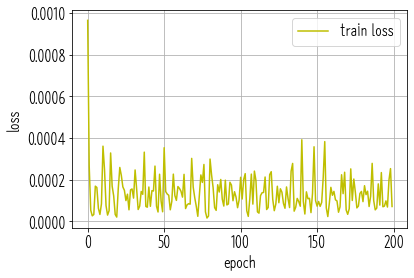

result :  0.002304180443067761


In [83]:

# 5. 모델 학습 과정 표시하기
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 15

fig, loss_ax = plt.subplots()
loss_ax.grid()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper right')
plt.show()
print('result : ', results)

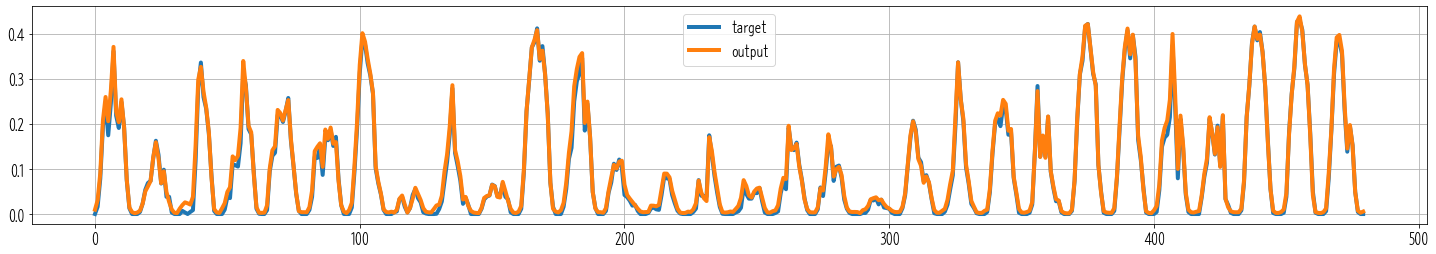

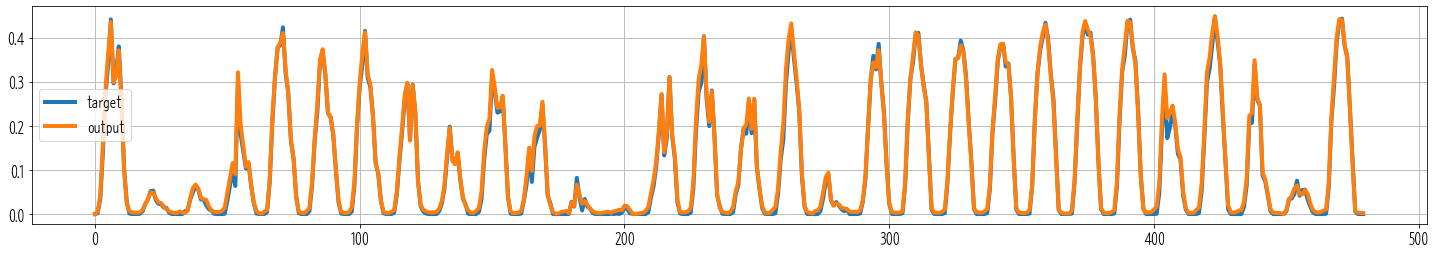

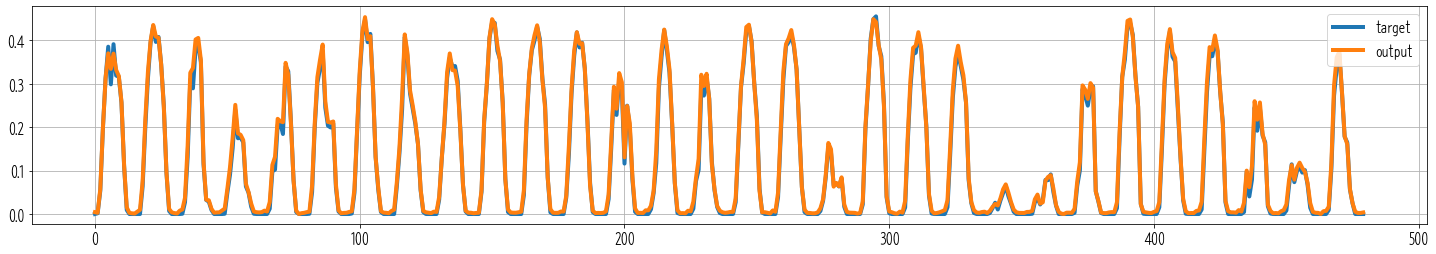

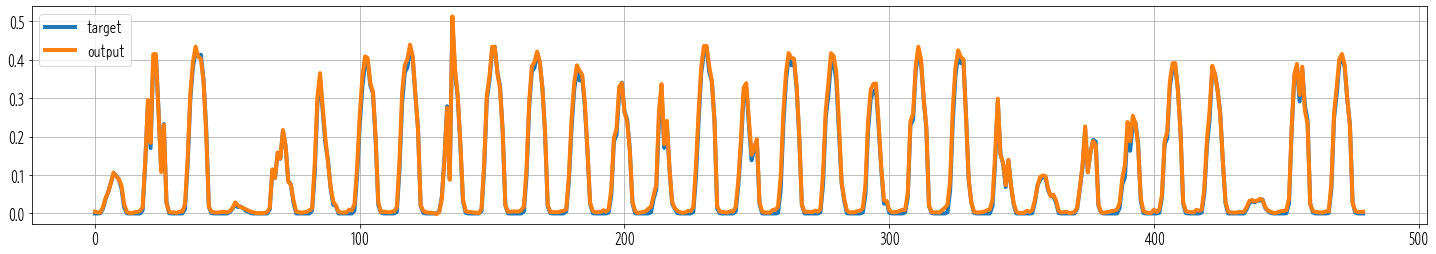

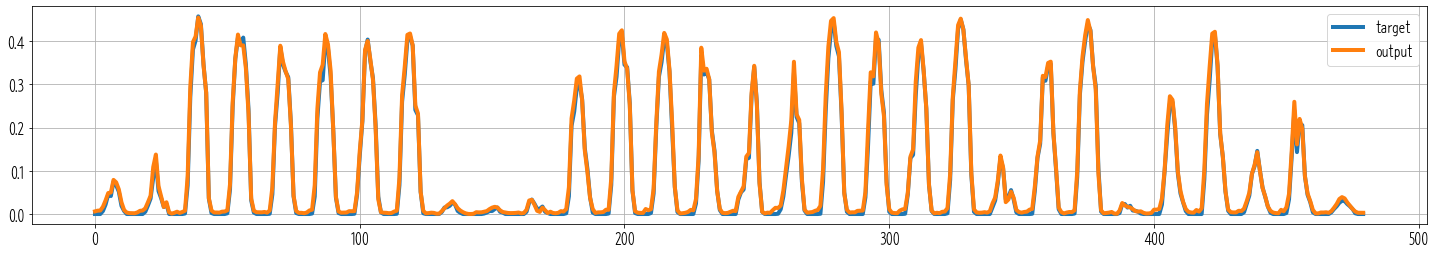

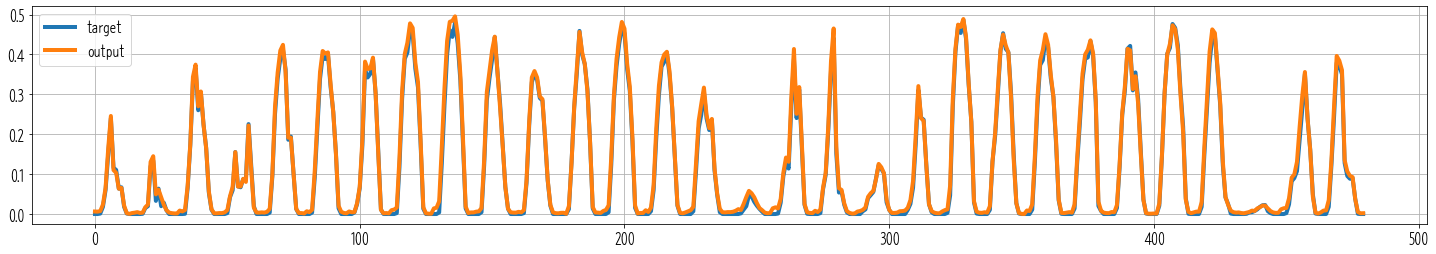

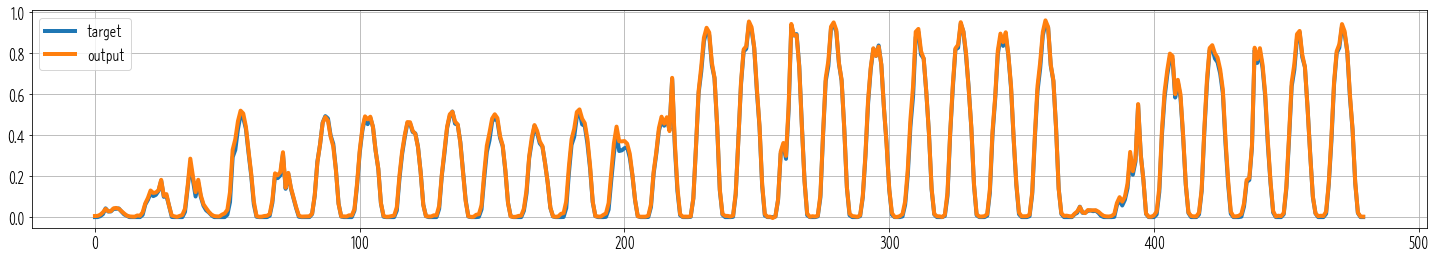

In [84]:
plotY = trainY.reshape(-1,1)
plotY_pred = model.predict(trainX).reshape(-1,1)

step = hoursteps*30
for i in range(0, plotY.shape[0]-step, step):
#for i in range(0, 240-step, step):
    plt.rcParams["figure.figsize"] = (25,4)
    plt.plot(plotY[i:i+step], label="target",linewidth=4, alpha=1)
    plt.plot(plotY_pred[i:i+step], label="output",linewidth=4, alpha=1)
    #plt.plot(plotY[i:i+step], 'r-', label="target",linewidth=2, alpha=1)
    #plt.plot(plotY_pred[i:i+step], 'y-', label="output",linewidth=2, alpha=1)
    plt.grid()
    plt.legend()
    plt.show()

#print(plotY_pred)

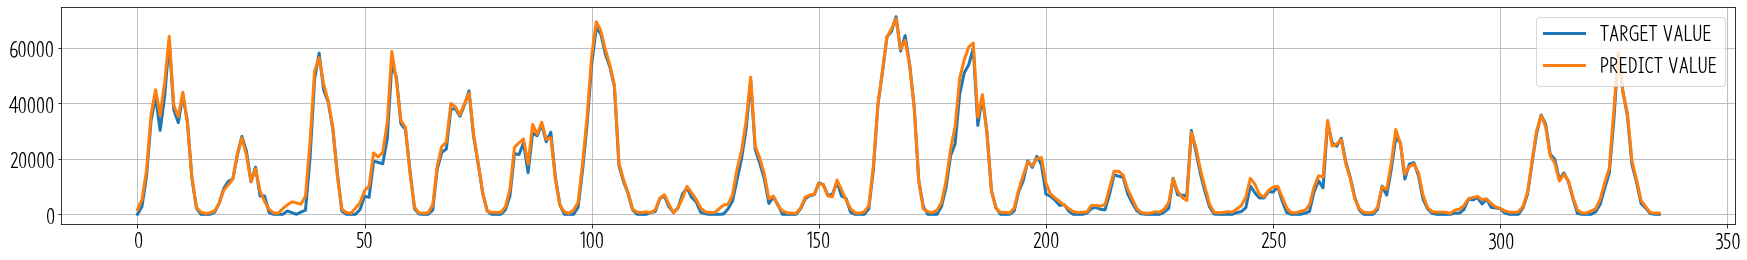

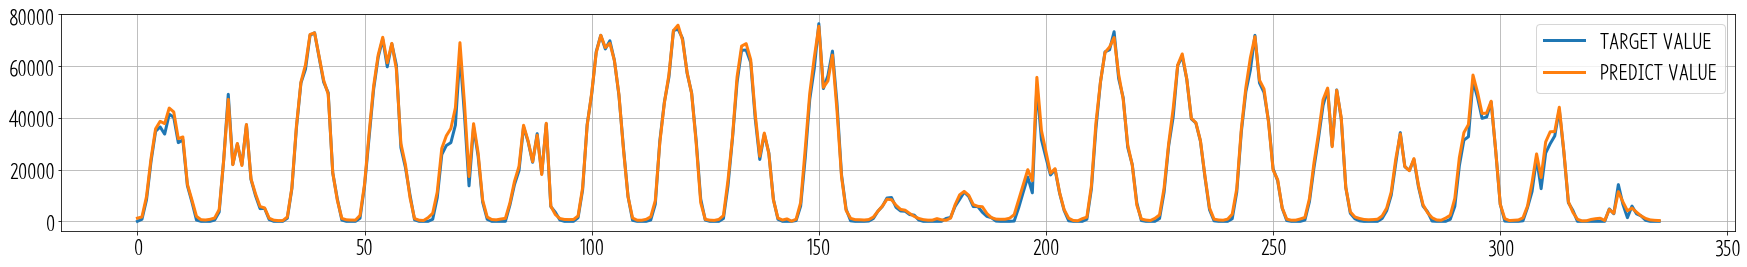

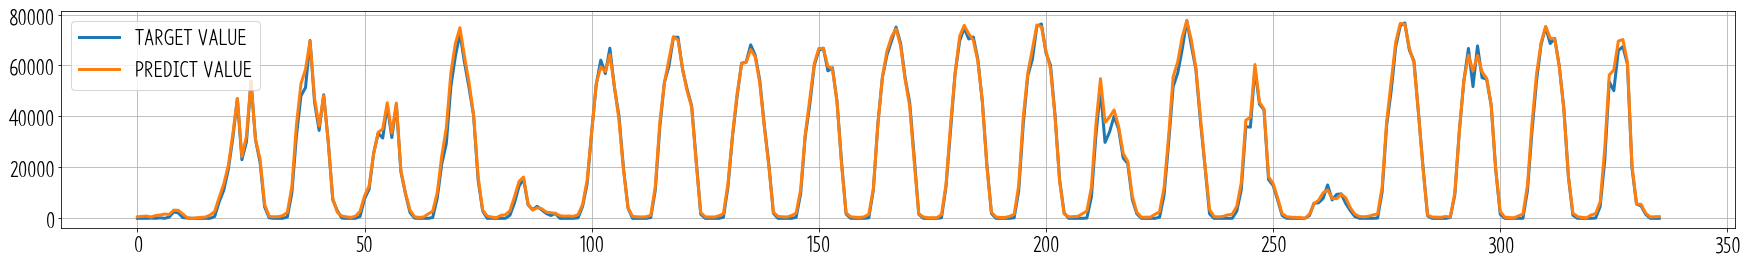

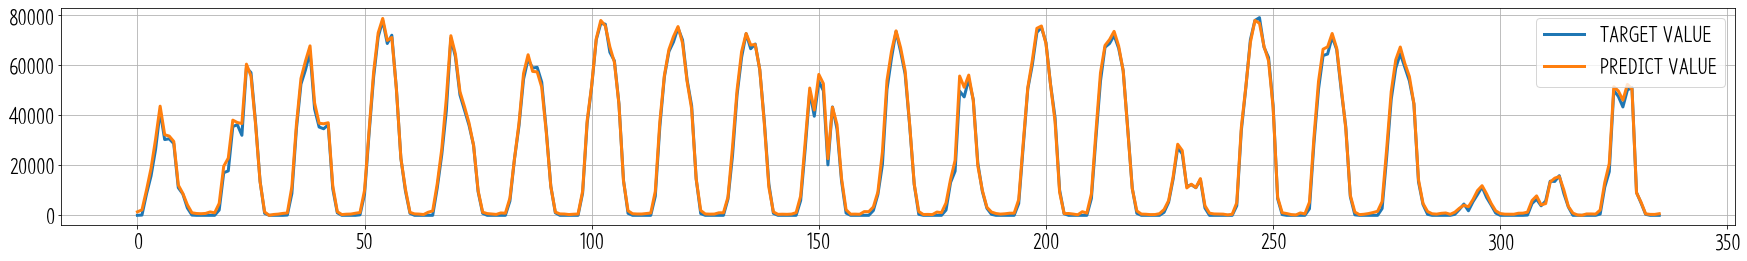

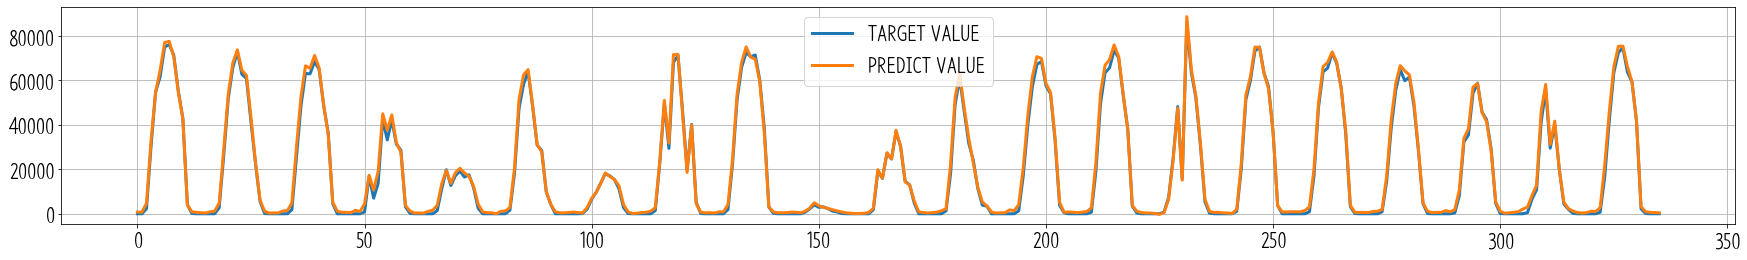

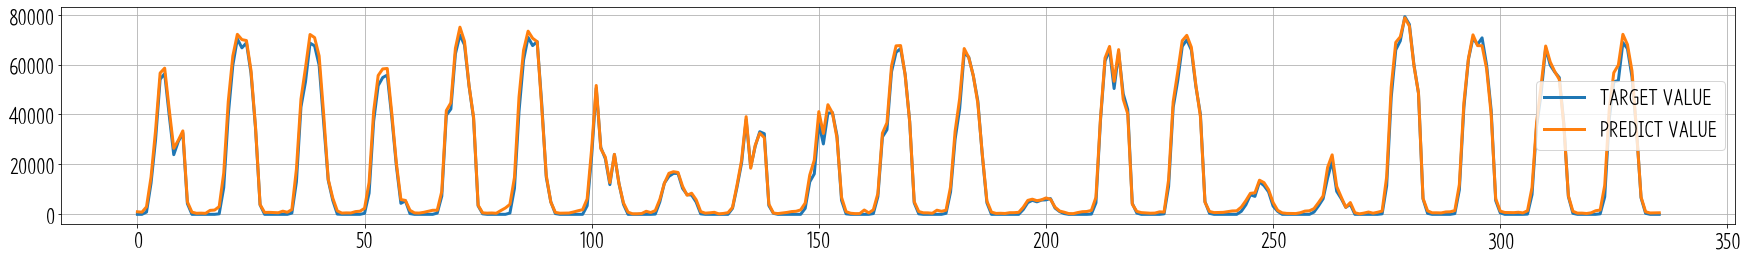

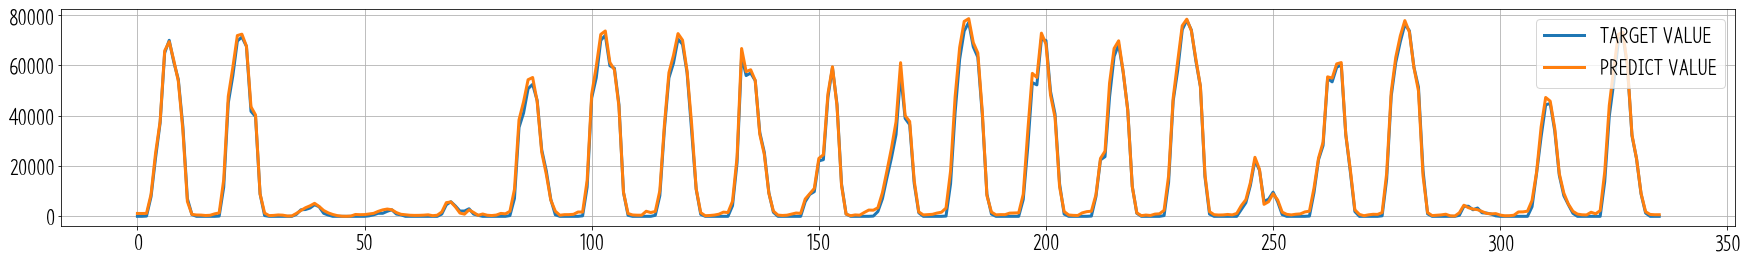

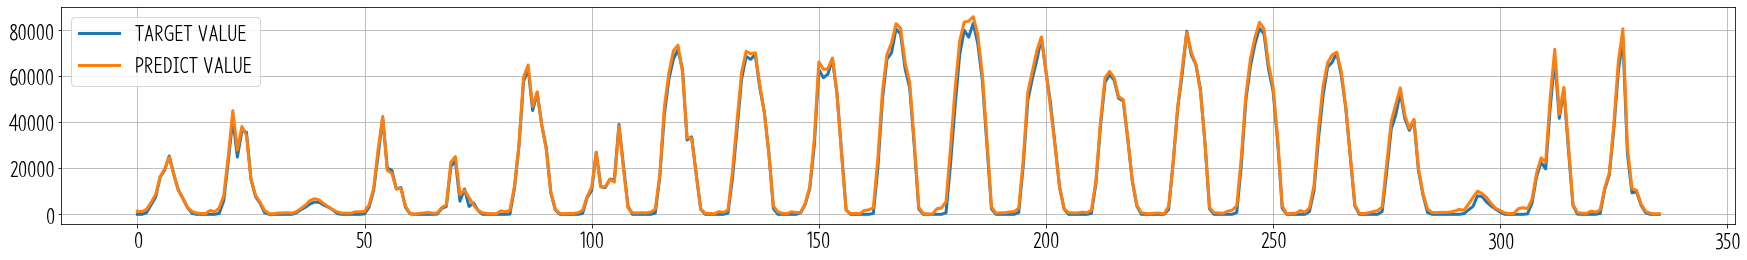

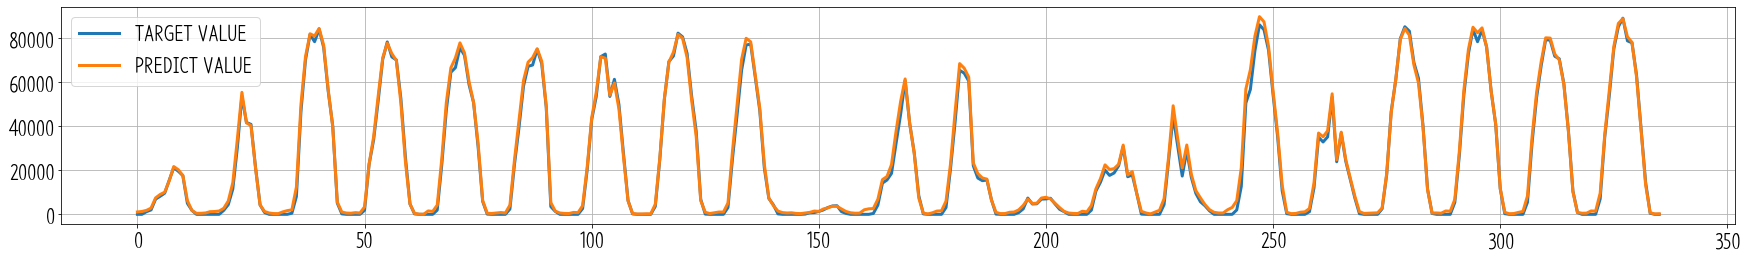

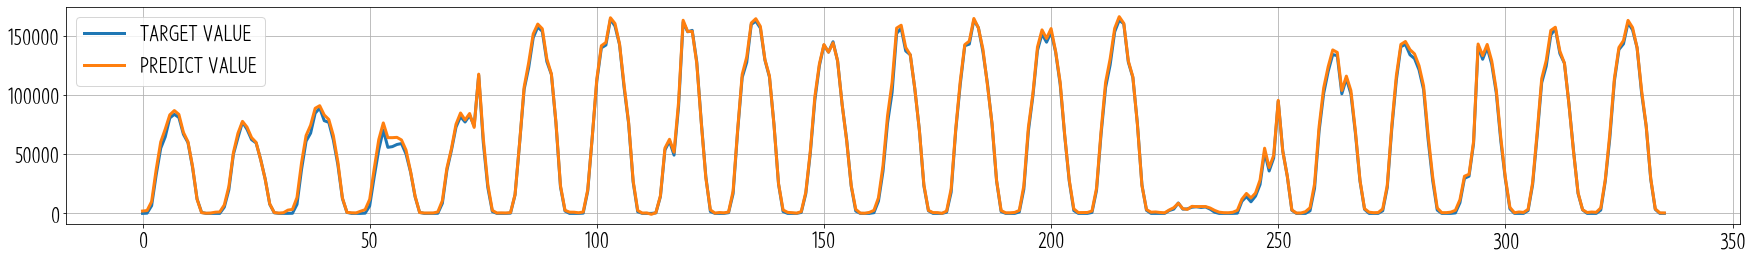

<Figure size 2160x288 with 0 Axes>

In [85]:

plt.rcParams['font.size'] = 20
y = sc_pow.inverse_transform(trainY[:,:,0])
plotY = y.reshape(-1,1)

pred = model.predict(trainX)[:,:,0]
#pred[pred<0] = 0

x = sc_pow.inverse_transform(pred)
plotY_pred = x.reshape(-1,1)

acc_list = []
target_list=[]

step = hoursteps*21
for i in range(0, plotY.shape[0]-step, step):
#for i in range(0, plotY.shape[0]-hoursteps, hoursteps):
#for i in range(0, 240-step, step):
    plt.rcParams["figure.figsize"] = (30,4)
    plt.plot(plotY[i:i+step], label="TARGET VALUE",linewidth=3)#,linewidth=4, alpha=0.7)
    plt.plot(plotY_pred[i:i+step],label="PREDICT VALUE",linewidth=3)#,linewidth=2, alpha=1)
    #plt.plot(plotY[i:i+step], 'r-', label="target",linewidth=2, alpha=1)
    #plt.plot(plotY_pred[i:i+step], 'y-', label="output",linewidth=2, alpha=1)
    plt.grid()
    plt.legend()
    plt.show()

#plt.tight_layout()
plt.savefig(dir_path+'/predict.jpg')
#plt.show()
#print(plotY_pred)

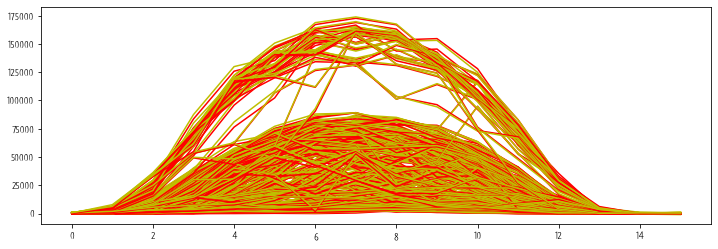

In [57]:
y = sc_pow.inverse_transform(trainY[:,:,0])
plotY = y.reshape(-1,1)

pred = model.predict(trainX)[:,:,0]
#pred[pred<0] = 0

x = sc_pow.inverse_transform(pred)
plot_pred = x.reshape(-1,1)

acc_list = []
target_list=[]

for i in range(0, plotY.shape[0]-hoursteps, hoursteps):
    plt.rcParams["figure.figsize"] = (12,4)
    plt.plot(plotY[i:i+hoursteps], 'r-', label="target")
    plt.plot(plot_pred[i:i+hoursteps], 'y-', label="output")
    #plt.legend()
    #plt.show()
    
    pred = np.sum(plot_pred[i:i+hoursteps])
    target      = round(np.sum(plotY[i:i+hoursteps]), 2)
    
    error       = round(np.abs(target-pred), 2)
    error_rate  = round(error/target, 2)
    acc_rate    = np.max([round((1.0-error_rate)*100, 2),0])
    
    target_list.append(target)
    acc_list.append(acc_rate)
    #print("   pred: ",pred," | target: ",target," | error: ",error," | err rate: ",error_rate," | acc: ",acc_rate,sep="")

mean(acc rate): nan


c:\users\vislab_phy\anaconda3\envs\py37\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\vislab_phy\anaconda3\envs\py37\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


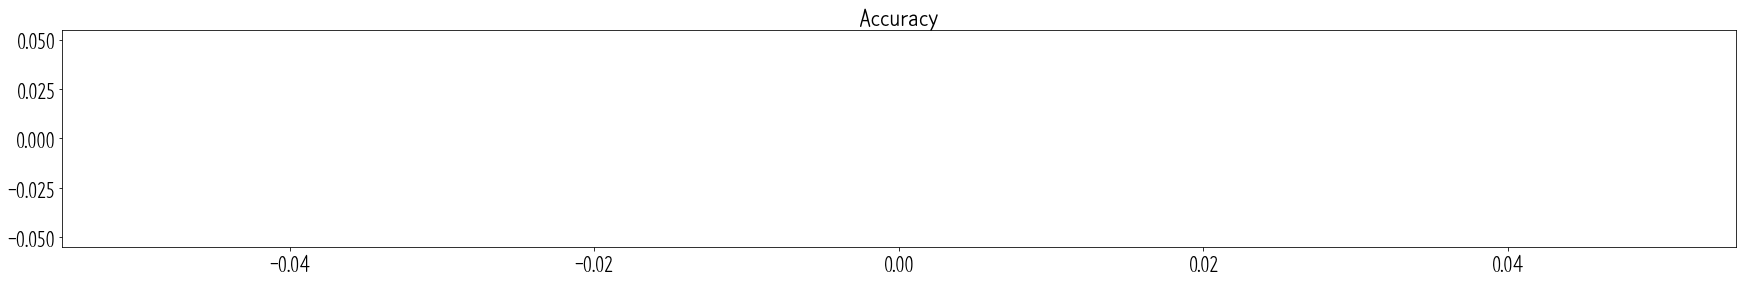

[]


In [64]:
print("mean(acc rate): ",np.mean(acc_list),sep='')
    
#plotAcc = np.array(acc_list).reshape(-1,1)
plt.plot(acc_list, 'ro-')
plt.title("Accuracy")
plt.show()
print(acc_list)


# model들 acc 평균 출력

In [65]:

from keras.models import load_model

mod = 'summer'

#get test data
X_test = np.load("npset/"+season_mod+"_testX.npy")
y_test = np.load("npset/"+season_mod+"_testY.npy")

#get pow scale form
#powdata, scaler = libs_yeon.get_pow()

print("X_test : ", X_test.shape)
print("y_test : ", y_test.shape)

n_dataset   = y_test.shape[0]
acc_list    = []
acc_model   = []
model       = []

for i in range(n_model):
    model.append(load_model('model/model_'+season_mod+'_'+str(i)+'.h5'))
    acc_model.append(0)
    
print("[ dataset ]")
for i in range(n_dataset):
    #if(i in [2,3,4,5,6,7,8]): continue;
    y = sc_pow.inverse_transform(y_test[i:i+1,:,0])

    for m in range(n_model):
        #print("(model",m+1,")\t",end="")

        pred = model[m].predict([X_test[i:i+1]])
        pred[pred<0] = 0
        pred = pred[:,:,0]
        pred = sc_pow.inverse_transform(pred)
        pred = np.sum(pred)

        target      = round(np.sum(y), 2)
        error       = round(np.abs(target-pred), 2)
        error_rate  = np.min([round(error/target, 2),1])
        acc_rate    = round((1.0-error_rate)*100, 2)
        acc_list.append(acc_rate)
        acc_model[m] += acc_rate
                 
        #print("   pred: ",pred," | target: ",target," | error: ",error," | err rate: ",error_rate," | acc: ",acc_rate,sep="")
        
    #print("acc rate: ",np.mean(acc_list[-n_model:]),sep='')
    print(np.mean(acc_list[-n_model:]), " / ",sep='', end='')
        
print("\n----------------------------------------------")
print("mean(acc rate): ",np.mean(acc_list),sep='')
print("----------------------------------------------")
print("[ model ]")
for i in range(n_model):
    acc_model[i] = round(acc_model[i]/(n_dataset),2)
    print(acc_model[i])

X_test :  (34, 48, 16)
y_test :  (34, 16, 1)


RuntimeError: It looks like you are trying to use a version of multi-backend Keras that does not support TensorFlow 2.0. We recommend using `tf.keras`, or alternatively, downgrading to TensorFlow 1.14.